In [2]:
import torch
import matplotlib.pyplot as plt
import datasets, models, train, utils
import torchvision.transforms as transforms
from torchvision.transforms.functional import affine
import numpy as np

In [3]:
# !pip install wandb

In [4]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [5]:
# create dataloaders
train_all_ds, train_lab_ds, train_unlab_ds, valid_ds, test_ds  = datasets.create_dataloaders()

images.shape=torch.Size([8, 3, 224, 224]), labels.shape=torch.Size([8, 224, 224])
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)


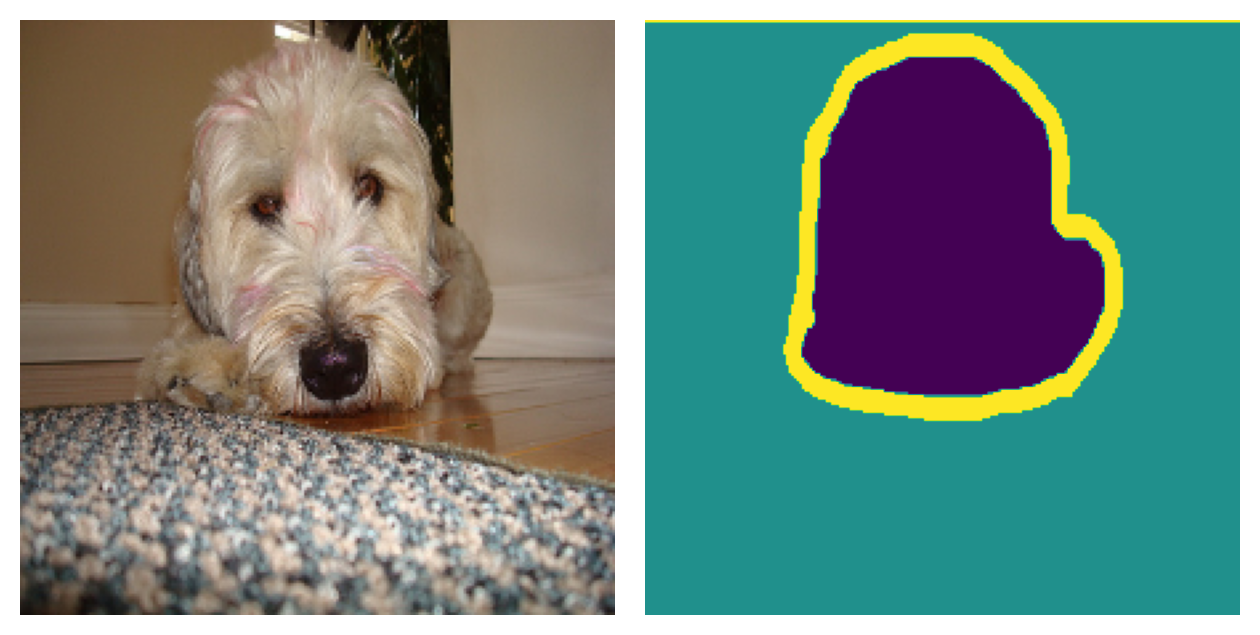

In [6]:
# plot dataset sample
images, labels = next(iter(train_all_ds))
print(f'{images.shape=}, {labels.shape=}')
print(labels[0]) 
#    the labels are:
#    - 0: foreground
#    - 1: background
#    - 2: not classified 
fig, axs = plt.subplots(1, 2)
axs[0].imshow((utils.unnormalize_images(images))[0].permute(1, 2, 0))
axs[1].imshow(labels[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [33]:
angle = np.random.randint(-10, 10)
translate = [np.random.randint(-10, 10), np.random.randint(-10, 10)]
shear = np.random.randint(-10, 10)
scale = np.random.uniform(0.9, 1.1)
img_a = affine(images, angle, translate, scale, shear)
mask_a = affine(labels, angle, translate, scale, shear, fill=2)

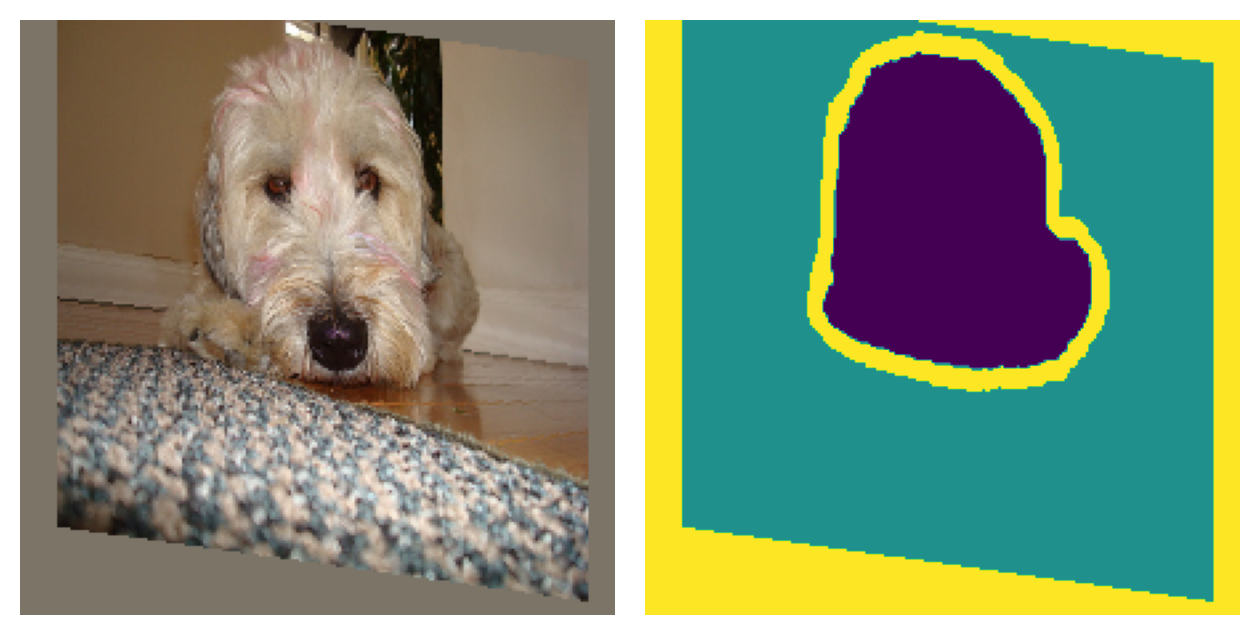

In [34]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow((utils.unnormalize_images(img_a))[0].permute(1, 2, 0))
axs[1].imshow(mask_a[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
%%time
# test model
model = models.load_deeplab()
logits = model(images)['out'][:, 0]
logits.shape

CPU times: user 13.8 s, sys: 1.28 s, total: 15.1 s
Wall time: 19.7 s


torch.Size([8, 224, 224])

In [6]:
# checking if deeplab head gets different weights
model1 = models.load_deeplab(use_imagenet_weights=True, large_resnet=False)
model2 = models.load_deeplab(use_imagenet_weights=True, large_resnet=False)

for name in model1.classifier.state_dict().keys():
            
            if not torch.allclose(
                model1.classifier.state_dict()[name], model2.classifier.state_dict()[name]
            ):
                    print('layer NOT the same:', name)
                    #print(model1.classifier.state_dict()[name])
                    #print(model2.classifier.state_dict()[name])

            else:
                print('layer the same:',name)  
                #print(model2.classifier.state_dict()[name])       
                # looks like only 0 and 1 init weights match up, random ones indeed don't  

layer NOT the same: 0.convs.0.0.weight
layer the same: 0.convs.0.1.weight
layer the same: 0.convs.0.1.bias
layer the same: 0.convs.0.1.running_mean
layer the same: 0.convs.0.1.running_var
layer the same: 0.convs.0.1.num_batches_tracked
layer NOT the same: 0.convs.1.0.weight
layer the same: 0.convs.1.1.weight
layer the same: 0.convs.1.1.bias
layer the same: 0.convs.1.1.running_mean
layer the same: 0.convs.1.1.running_var
layer the same: 0.convs.1.1.num_batches_tracked
layer NOT the same: 0.convs.2.0.weight
layer the same: 0.convs.2.1.weight
layer the same: 0.convs.2.1.bias
layer the same: 0.convs.2.1.running_mean
layer the same: 0.convs.2.1.running_var
layer the same: 0.convs.2.1.num_batches_tracked
layer NOT the same: 0.convs.3.0.weight
layer the same: 0.convs.3.1.weight
layer the same: 0.convs.3.1.bias
layer the same: 0.convs.3.1.running_mean
layer the same: 0.convs.3.1.running_var
layer the same: 0.convs.3.1.num_batches_tracked
layer NOT the same: 0.convs.4.1.weight
layer the same: 0

## Test CutMix function

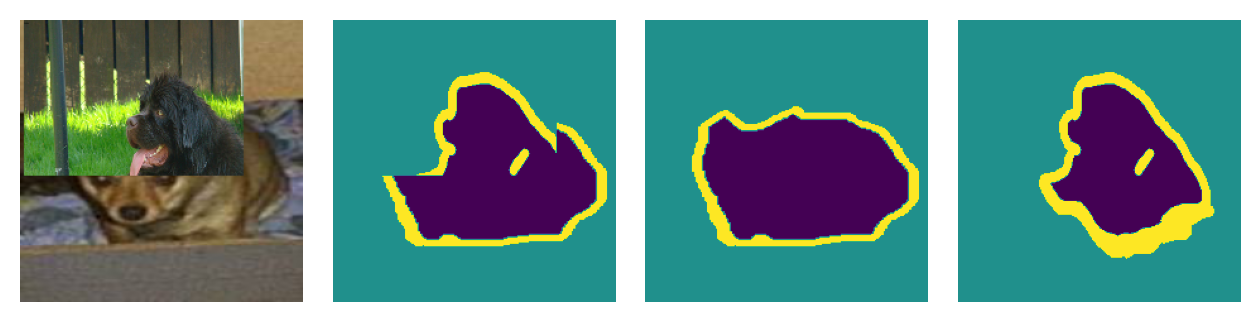

In [18]:

images, labels = next(iter(train_all_ds))

cutmix_input, input_a, input_b, cutmix_target_a, cutmix_target_b, mask = utils.cutmix(images, labels)

test_target = utils.apply_cutmix_mask_to_output(cutmix_target_a, cutmix_target_b, mask)

fig, axs = plt.subplots(1, 4)
axs[0].imshow((utils.unnormalize_images(cutmix_input))[0].permute(1, 2, 0))
axs[1].imshow(test_target[0])
axs[2].imshow(cutmix_target_a[0])
axs[3].imshow(cutmix_target_b[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
set(test_target.flatten())

{tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(2, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(2, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(

## Test CutOut function

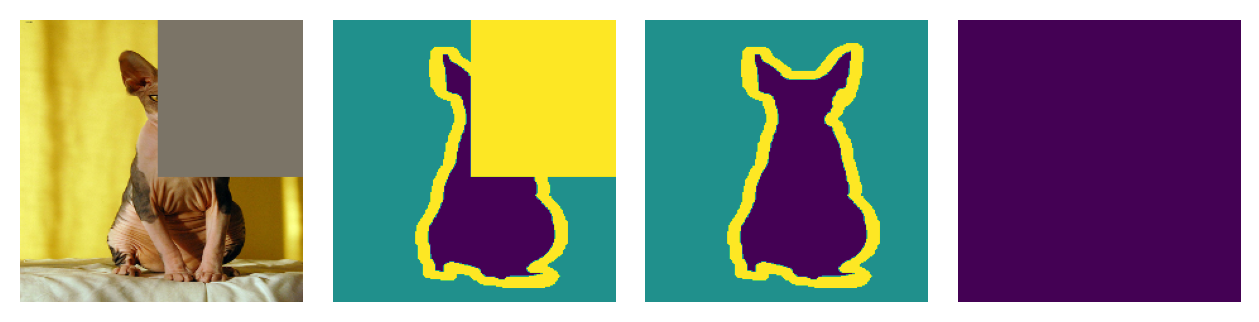

In [24]:
# test cutout function
images, labels = next(iter(train_all_ds))

cutmix_input, input_a, input_b, cutmix_target_a, cutmix_target_b, mask = utils.cutout(images, labels)

test_target = utils.apply_cutout_mask_to_output(cutmix_target_a, mask)

fig, axs = plt.subplots(1, 4)
axs[0].imshow((utils.unnormalize_images(cutmix_input))[0].permute(1, 2, 0))
axs[1].imshow(test_target[0])
axs[2].imshow(cutmix_target_a[0])
axs[3].imshow(cutmix_target_b[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


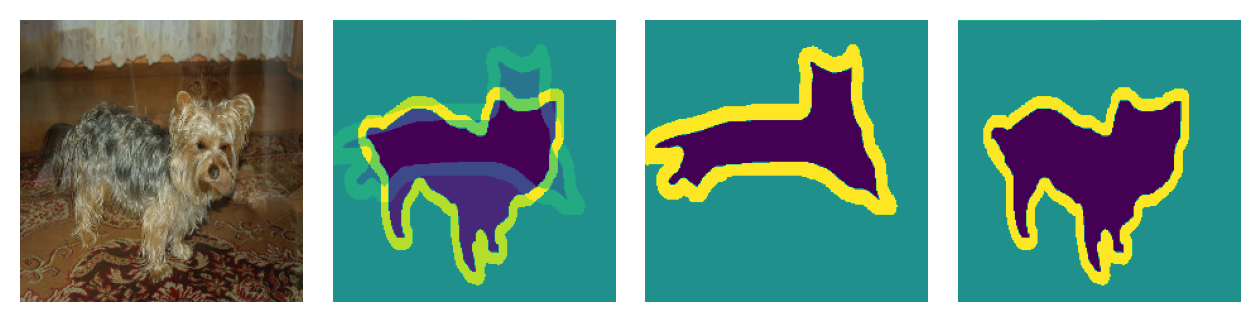

In [31]:
# Test mixup function
images, labels = next(iter(train_all_ds))

mixup_input, input_a, input_b, mixup_target_a, mixup_target_b, lam = utils.mixup(images, labels)

test_target = lam * mixup_target_a + (1 - lam) * mixup_target_b

fig, axs = plt.subplots(1, 4)
axs[0].imshow((utils.unnormalize_images(mixup_input))[0].permute(1, 2, 0))
axs[1].imshow(test_target[0])
axs[2].imshow(mixup_target_a[0])
axs[3].imshow(mixup_target_b[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()
